### Training of modified U-Net for Optic Disc on DRIONS-DB database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/05.03,02:40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import glob
import os
from datetime import datetime

import matplotlib.pyplot as plt
import skimage
import skimage.exposure
#import warnings
#warnings.simplefilter('ignore')
import tensorflow as tf
from sklearn.model_selection import KFold
%matplotlib inline
import h5py
from dual_IDG import DualImageDataGenerator

In [142]:
import keras as keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras import backend as K

In [143]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [144]:
# K.set_image_data_format('channels_last')

In [145]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.) # batch_flatten：将一个 nD 张量变成一个 第 0 维相同的 2D 张量
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.) # batch_flatten：逐元素clip（将超出指定范围的数强制变为边界值）
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [146]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [147]:
# channels_first
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)

# channels_last
def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [148]:
# h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRIONS_DB.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [149]:
# def get_unet_light(img_rows=256, img_cols=256):
#     inputs = Input((3, img_rows, img_cols))
#
#     # contract path
#     conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
#     conv1 = Dropout(0.3)(conv1)
#     conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     print("pool1", pool1.get_shape())
#
#     conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
#     conv2 = Dropout(0.3)(conv2)
#     conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     print("pool2", pool2.get_shape())
#
#     conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
#     conv3 = Dropout(0.3)(conv3)
#     conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     print("pool3", pool3.get_shape())
#
#     conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
#     conv4 = Dropout(0.3)(conv4)
#     conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#     print("pool4", pool4.get_shape())
#
#     # bottom
#     conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
#     conv5 = Dropout(0.3)(conv5)
#     conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)
#     print("convm", conv5.get_shape())
#
#     # expansive path
#     up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
#     conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
#     conv6 = Dropout(0.3)(conv6)
#     conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)
#
#     up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
#     conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
#     conv7 = Dropout(0.3)(conv7)
#     conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)
#
#     up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
#     conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
#     conv8 = Dropout(0.3)(conv8)
#     conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)
#
#     up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
#     conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
#     conv9 = Dropout(0.3)(conv9)
#     conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)
#
#     conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
#     #conv10 = Flatten()(conv10)
#
#     model = Model(input=inputs, output=conv10)
#
#     return model

In [150]:
from CARUNet_modified import *
model = CARUNet_modified(input_size=(256, 256, 3))
model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

conv1 (?, 256, 256, 32)
conv1 (?, 256, 256, 32)
pool1 (?, 128, 128, 32)
pool2 (?, 64, 64, 64)
pool3 (?, 32, 32, 64)
pool4 (?, 16, 16, 64)
convm (?, 16, 16, 64)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 256, 256, 3)  12          input_7[0][0]                    
__________________________________________________________________________________________________
activation_355 (Activation)     (None, 256, 256, 3)  0           batch_normalization_271[0][0]    
__________________________________________________________________________________________________
conv2d_259 (Conv2D)            

E:\PycharmProjects\optic-nerve-cnn-main\scripts\CARUNet_modified.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  model = Model(input=inputs, output=output_layer)


#### DRIONS-DB

Accessing data, preparing train/validation sets division:

In [151]:
X = h5f['DRIONS-DB/256 px/images']
Y = h5f['DRIONS-DB/256 px/disc']
# X = np.reshape(X, (len(X), 256, 256, 3))  # adapt this if using `channels_first` image data format
# X = np.reshape(X, (len(X), 256, 256, 1))  # adapt this if using `channels_first` im

In [152]:
X, Y

(<HDF5 dataset "images": shape (110, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (110, 256, 256, 1), type "|u1">)

In [153]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[ 22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109] [22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  

In [154]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [155]:
len(X), len(train_idx), len(test_idx)

(110, 88, 22)

#### Generator of augmented data:

In [156]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0, dim_ordering='channels_first')
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [157]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X) # 把第一个channel移到第三个channel，其它相对位置不变
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    # batch_X = tf_to_th_encoding(batch_X)  # 把第三个channel移到第一个channel，其它相对位置不变
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)

        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X) # channels_first
        print(batch_X.shape)
        batch_y = tf_to_th_encoding(batch_y) # channels_first
        print(batch_y.shape)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [158]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = next(gen)
batch[0].shape

(1, 3, 256, 256)
(1, 1, 256, 256)


(1, 256, 256, 3)

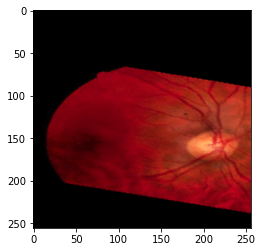

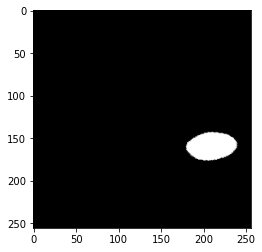

In [159]:
# fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
fig = plt.imshow(batch[0][0])
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [160]:
# %m 月份（01-12）
# %d 月内中的一天（0-31）
# %H 24小时制小时数（0-23）
# %M 分钟数（00=59）
arch_name = "U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))

In [161]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

(22, 3, 256, 256)
(22, 1, 256, 256)
(22, 256, 256, 3) (22, 1, 256, 256)


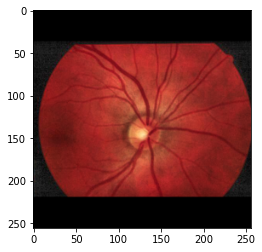

In [162]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(X_valid[0]); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [164]:
print(weights_folder)
weights_folder = weights_folder.replace('\\', '/')
path_CSVLogger = weights_folder + '/training_log.csv'
path_ModelCheckpoint = weights_folder +  '/last_checkpoint.hdf5'
print('path_CSVLogger', path_CSVLogger)
print('path_ModelCheckpoint', path_ModelCheckpoint)
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1),
                              steps_per_epoch=99,
                              max_queue_size=1,
                              validation_data=(X_valid, Y_valid),
                              epochs=500, verbose=1)

E:/PycharmProjects/optic-nerve-cnn-main/models_weights/28.04,20:53,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss
path_CSVLogger E:/PycharmProjects/optic-nerve-cnn-main/models_weights/28.04,20:53,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/training_log.csv
path_ModelCheckpoint E:/PycharmProjects/optic-nerve-cnn-main/models_weights/28.04,20:53,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5
(1, 3, 256, 256)
(1, 1, 256, 256)
Epoch 1/500
(1, 3, 256, 256)
(1, 1, 256, 256)
(1, 3, 256, 256)
(1, 1, 256, 256)
 1/99 [..............................] - ETA: 1:44 - loss: 1.6414 - mean_IOU_gpu: 0.1049 - dice_metric: 0.1899(1, 3, 256, 256)
(1, 1, 256, 256)
 2/99 [..............................] - ETA: 1:37 - loss: 1.5222 - mean_IOU_gpu: 0.1201 - dice_metric: 0.2142(1, 3, 256, 256)
(1, 1, 256, 256)
 3/99 [..............................] - ETA: 1:34 - loss: 1.4459 - mean_IOU_gpu: 0.1362 

KeyboardInterrupt: 

### Visual check

In [ ]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [ ]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

Showing the best and the worst cases:

In [ ]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('drions_db_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('drions_db_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('drions_db_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {} (best)'.format(pred_iou[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {} (worst)'.format(pred_iou[worst_idx]))

### Loading model

In [ ]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recently modified file in a folder:
    model_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '05.03,02_40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss')
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].idxmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].idxmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].idxmax()])